# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
#!pip install -r requirements.txt 
# | grep -v "already satisfied"

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts =============================
platform win32 -- Python 3.13.9, pytest-9.0.2, pluggy-1.6.0 -- C:\Users\sebas\Documents\Projects\nanodegrees\UDACITY_DeepLearning\2_Landmark Classification and Tagging for Social Media\.venv\Scripts\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\sebas\Documents\Projects\nanodegrees\UDACITY_DeepLearning\2_Landmark Classification and Tagging for Social Media
collecting ... collected 1 item

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== warnings summary ===============================
src/transfer.py::test_get_model_transfer_learning
  C:\Users\sebas\Documents\Projects\nanodegrees\UDACITY_DeepLearning\2_Landmark Classification and Tagging for Social Media\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [ ]:
batch_size = 16                          # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2                         # fraction of the training data to reserve for validation
num_epochs = 50                          # number of epochs for training
num_classes = 50                         # number of classes. Do1 not change this
dropout = 0.319577254023257              # dropout for our model
learning_rate = 0.00012834072920501758   # Learning rate for SGD (or Adam)
opt = 'adam'                             # optimizer. 'sgd' or 'adam'
weight_decay = 0.00030887344657556904    # regularization. Increase this to combat overfitting

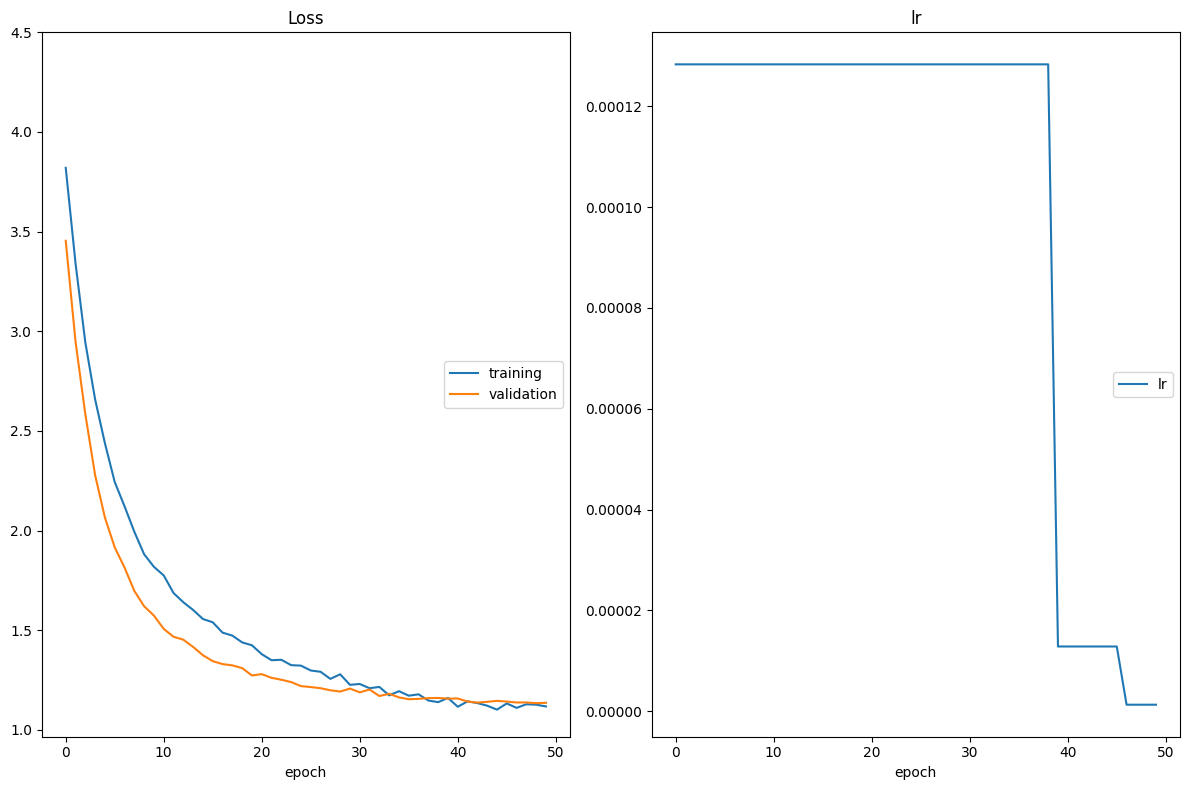

In [7]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ 

To arrive at the final CNN architecture, I used **transfer learning**: reusing a pretrained backbone and training only a new classifier head for the 50 landmark classes. Below are the steps and reasoning behind each choice.

### 1. Choosing the Backbone (Pretrained Model)

* **Approach:** I used a **pretrained** model from torchvision rather than training a CNN from scratch. The backbone is loaded with `getattr(models, model_name)(pretrained=True)` (e.g., `"resnet18"`).
* **Reasoning:** Pretrained models have already learned rich visual features (edges, textures, object parts) on large datasets like ImageNet. Landmark images share the same visual domain (natural scenes, buildings, nature), so these features transfer well. Training from scratch would require far more data and compute to reach similar accuracy.

### 2. Selecting ResNet18

* **Choice:** I used **ResNet18** as the default backbone (as in the notebook's `get_model_transfer_learning("resnet18", n_classes=num_classes)`).
* **Reasoning:** ResNet18 is a good trade-off between capacity and speed: it is deep enough to capture complex features (18 layers with skip connections) but lighter than ResNet50/101, so training and inference stay feasible on a single GPU. Skip connections also help gradient flow, which is useful when fine-tuning.

### 3. Freezing the Backbone

* **Implementation:** All parameters of the pretrained model are frozen with `param.requires_grad = False` for every `param` in `model_transfer.parameters()`.
* **Reasoning:** Freezing preserves the pretrained features and avoids **catastrophic forgetting**. Only the new classifier head is trained, so we need to learn far fewer parameters, which reduces overfitting and training time. For a medium-sized landmark dataset, this is usually sufficient; optionally, later layers could be unfrozen for fine-tuning if more data or epochs are available.

### 4. Replacing the Classifier Head

* **Implementation:** The original final fully connected layer is replaced. I read the number of backbone features with `num_ftrs = model_transfer.fc.in_features` (512 for ResNet18) and set `model_transfer.fc = nn.Linear(num_ftrs, n_classes)`.
* **Reasoning:** The pretrained model was trained for ImageNet's 1000 classes. Our task has 50 landmark classes, so the last layer must be replaced with one that maps the 512-dimensional feature vector to 50 class logits. Only this new layer has trainable parameters; it learns to combine the frozen backbone features for landmark classification.

### 5. No Extra Hidden Layers or Dropout in the Head

* **Choice:** The classifier is a single linear layer (512 → 50), with no extra hidden layer or dropout in the implemented `get_model_transfer_learning` function.
* **Reasoning:** With the backbone frozen and a relatively small head, overfitting is already mitigated. Data augmentation (e.g., in the dataloader) further regularizes. A single linear layer keeps the setup simple and fast to train; adding dropout or a hidden layer could be tried if validation accuracy suggested overfitting.

### Suitability for the Current Problem

This architecture is well suited to landmark classification because:

* **Strong, reusable features:** The pretrained ResNet18 backbone provides high-level visual representations (e.g., structures, textures, scene layout) that are relevant for distinguishing landmarks, without needing a huge dataset to learn them from scratch.
* **Efficient use of data:** With only the final layer trained, the model needs fewer samples to reach good accuracy (e.g., >60% test accuracy as required), which fits the size of the landmark dataset.
* **Aligned domain:** Landmark images are natural photographs similar to ImageNet; the pretrained features transfer effectively, unlike in very different domains (e.g., medical or satellite imagery) where more fine-tuning or a different backbone might be needed.
* **Manageable compute:** ResNet18 is lightweight enough for training and deployment on typical hardware, while still being expressive enough for 50-way classification.
* **Standard input size:** Using 224×224 inputs (as in the data pipeline) matches the backbone's expected resolution and is a standard choice for transfer learning, so no extra preprocessing is required.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [8]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 79/79 [00:09<00:00,  7.97it/s]

Test Loss: 0.945022


Test Accuracy: 76% (957/1250)


0.9450218242510586

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [9]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [00:42<00:00, 29.18it/s]


Accuracy: 0.764


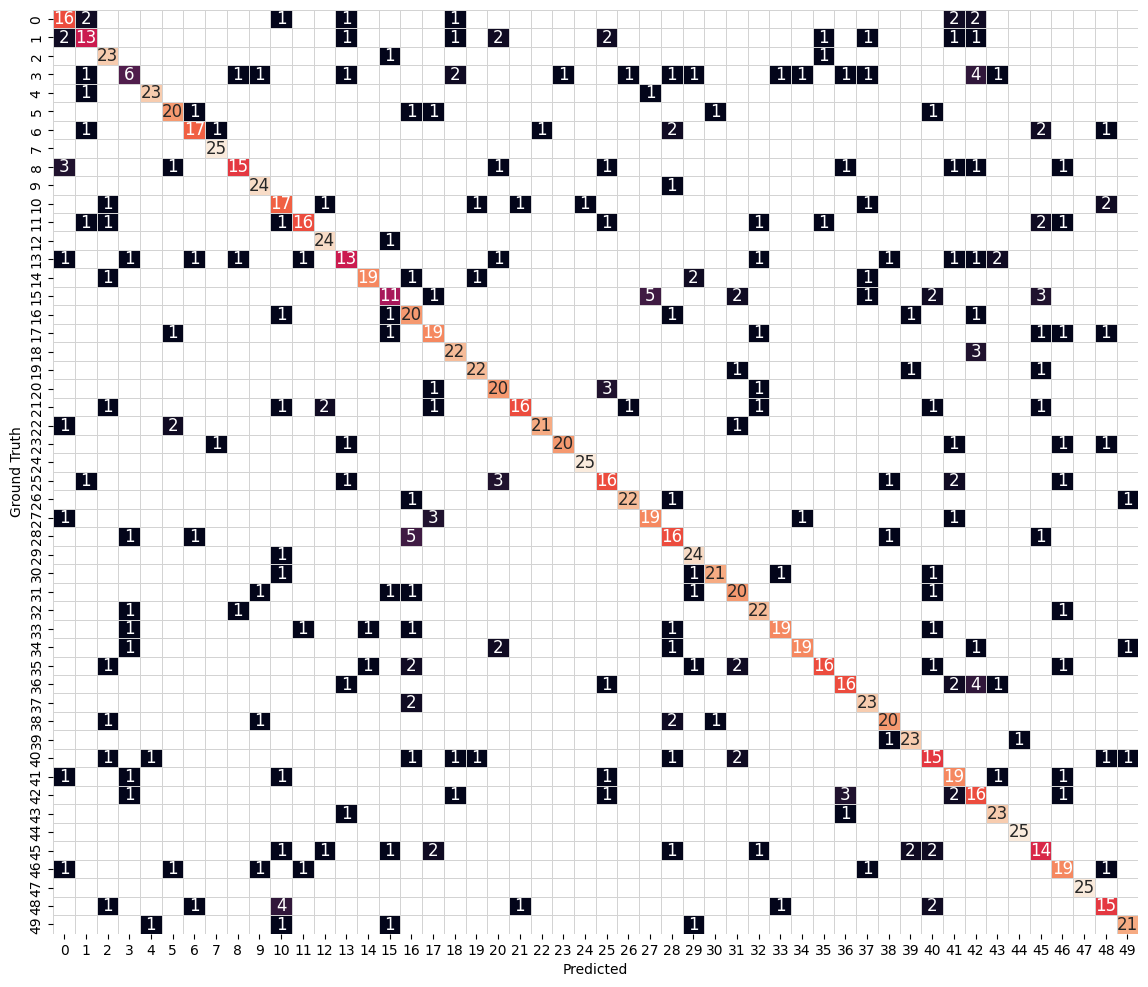

In [10]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)